In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import model_selection as sk
import os, re, h5py, shutil
from urllib.request import urlretrieve
from urllib.error import HTTPError
import sklearn
from os import listdir

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
folder = sklearn.model_selection.KFold(n_splits=3, shuffle=True, random_state=42)

In [3]:
# from os import listdir
# directory = "/home/ubuntu/Downloads/FERG_DB_256/Images"
# files_dir =  listdir(directory)
# newlist = []
# for names in files_dir:
#     if names.endswith(".png"):
#         newlist.append(names)
# d = {'names': newlist}
# df = pd.DataFrame(data = d)

In [4]:
def file_checkup(drt):
    directory = drt #"/home/ubuntu/Downloads/FERG_DB_256/Images"
    files_dir =  listdir(directory)
    newlist = []
    for names in files_dir:
        try:
            if names.endswith(".png"):
                if tf.keras.preprocessing.image.load_img(drt+'/{}'.format(names)):
                    newlist.append(names)
        except OSError:
            continue
    d = {'names': newlist}
    df = pd.DataFrame(data = d)
    return df

In [18]:
# df = file_checkup('./Images')

,names
count,55766
unique,55766
top,mery_sadness_704.png
freq,1


In [6]:
# df.to_csv('image_lst.csv')

In [19]:
df = pd.read_csv('image_lst.csv')
df.head()

,Unnamed: 0,names
0,0,aia_anger_1000.png
1,1,aia_anger_1001.png
2,2,aia_anger_1002.png
3,3,aia_anger_1003.png
4,4,aia_anger_1004.png


In [20]:
import matplotlib.image as mpimg

img_paths = []
img_names = []
for img in os.listdir('./Images')[0:90:10]:
    img_paths.append(mpimg.imread('./Images/' + img))
    img_names.append(img.split('.')[0])
    
print (len(img_paths))

9


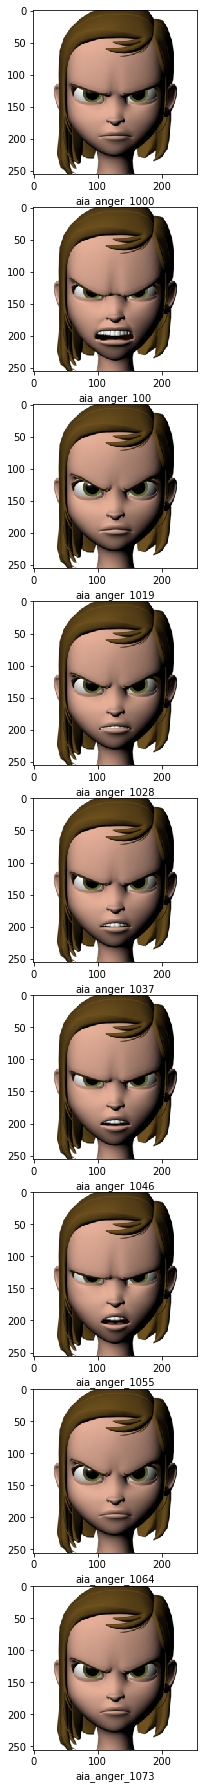

In [21]:
plt.figure(figsize = (32, 32))
    
for name, (i, img) in zip(img_names, enumerate(img_paths)):
    plt.subplot(int('{}1{}'.format(len(img_paths),i+1)))
    plt.imshow(img)
    plt.xlabel(name)

In [22]:
df.index.values

array([    0,     1,     2, ..., 55763, 55764, 55765])

In [23]:
folds = []
for fold_idx, split in enumerate(folder.split(X=df.index.values)):
    folds.append(split)

In [24]:
fold = folds[0]
fold[0]

array([    0,     2,     3, ..., 55763, 55764, 55765])

In [25]:
tst_df = df.loc[fold[0]]
tst_df[:5], len(tst_df)

(   Unnamed: 0               names
 0           0  aia_anger_1000.png
 2           2  aia_anger_1002.png
 3           3  aia_anger_1003.png
 5           5  aia_anger_1005.png
 8           8  aia_anger_1008.png, 37177)

In [26]:
"""cl here stands for class, as in 'anger', 'disgust', etc..."""

def create_direct(cl):
    newpath = r'./{}'.format(cl)
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        os.makedirs(newpath+'/train')
        os.makedirs(newpath+'/train/pos')
        os.makedirs(newpath+'/train/neg')
        os.makedirs(newpath+'/valid')
        os.makedirs(newpath+'/valid/pos')
        os.makedirs(newpath+'/valid/neg')

def cl_setup_folds(cl):
    os.mkdir('/'+str(cl)+'/train')
    os.mkdir('/'+str(cl)+'/train/pos')
    os.mkdir('/'+str(cl)+'/train/neg')
    os.mkdir('/'+str(cl)+'/valid')
    os.mkdir('/'+str(cl)+'/valid/pos')
    os.mkdir('/'+str(cl)+'/valid/neg')

def make_folds(df):
    folds = []
    for fold_idx, split in enumerate(folder.split(X=df.index.values)):
        folds.append(split)
    return folds

def cl_run_k_fold(df, k, cl):
    fold = folds[k]
    path = r'./{}'.format(cl)
    train_df = df.loc[fold[0]]
    train_pos = train_df.loc[train_df['names'].map(lambda x : True if str(x).split('_')[1] == '{}'.format(cl) else False)]
    train_neg = train_df.loc[train_df['names'].map(lambda x : True if str(x).split('_')[1] != '{}'.format(cl) else False)]
    valid_df = df.loc[fold[1]]
    valid_pos = valid_df.loc[valid_df['names'].map(lambda x : True if str(x).split('_')[1] == '{}'.format(cl) else False)]
    valid_neg = valid_df.loc[valid_df['names'].map(lambda x : True if str(x).split('_')[1] != '{}'.format(cl) else False)]
    for member in train_pos['names'].values:
        os.link('./Images/{}'.format(member), os.path.join(os.path.abspath(path+'/train/pos'), member))
    for member in train_neg['names'].values:
        os.link('./Images/{}'.format(member), os.path.join(os.path.abspath(path+'/train/neg'), member))
    for member in valid_pos['names'].values:
        os.link('./Images/{}'.format(member), os.path.join(os.path.abspath(path+'/valid/pos'), member))
    for member in valid_neg['names'].values:
        os.link('./Images/{}'.format(member), os.path.join(os.path.abspath(path+'/valid/neg'), member))
        
def cl_clean_up_folds(cl):
    path = r'./{}'.format(cl)
    def clean_up(folder):
        for the_file in os.listdir(folder):
            file_path = os.path.join(folder, the_file)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path): shutil.rmtree(file_path)
            except Exception as e:
                print(e)
    clean_up(newpath+'/train')
    os.rmdir(newpath+'/train')
    clean_up(newpath+'/valid')
    os.rmdir(newpath+'/valid')

In [27]:
def df_clean_up(df, directory):
    lst = df['names']
    for row, name in enumerate(lst):
        if name not in os.listdir(directory):
            print(name)
            df.drop(row, inplace=True)

In [28]:
create_direct('anger')

In [29]:
cl = 'anger'
path = r'./{}'.format(cl)
train_df = df.loc[fold[0]]
valid_df = df.loc[fold[1]]

In [30]:
train_pos = train_df.loc[train_df['names'].map(lambda x : True if str(x).split('_')[1] == '{}'.format(cl) else False)]
train_neg = train_df.loc[train_df['names'].map(lambda x : True if str(x).split('_')[1] != '{}'.format(cl) else False)]

In [31]:
valid_pos = valid_df.loc[valid_df['names'].map(lambda x : True if str(x).split('_')[1] == '{}'.format(cl) else False)]
valid_neg = valid_df.loc[valid_df['names'].map(lambda x : True if str(x).split('_')[1] != '{}'.format(cl) else False)]

In [32]:
for member in train_pos['names'].values:
    os.link('./Images/{}'.format(member), os.path.join(os.path.abspath(path+'/train/pos'), member))

In [33]:
for member in train_neg['names'].values:
    os.link('./Images/{}'.format(member), os.path.join(os.path.abspath(path+'/train/neg'), member))
for member in valid_pos['names'].values:
    os.link('./Images/{}'.format(member), os.path.join(os.path.abspath(path+'/valid/pos'), member))
for member in valid_neg['names'].values:
    os.link('./Images/{}'.format(member), os.path.join(os.path.abspath(path+'/valid/neg'), member))

In [34]:
train_feed = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20, width_shift_range=0.2,
    height_shift_range=0.2)
train_iter = train_feed.flow_from_directory(
    './anger/train/', target_size=(48, 48), follow_links=True, class_mode='categorical', batch_size=32)
valid_feed = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0, width_shift_range=0,
    height_shift_range=0)
valid_iter = valid_feed.flow_from_directory(
    './anger/valid/', target_size=(48, 48), follow_links=True, class_mode='categorical', batch_size=32)

Found 37177 images belonging to 2 classes.
Found 18589 images belonging to 2 classes.


In [35]:
conv_arch=[(32,3),(64,3),(128,3)]
dense=[64,2]
dropout=0.5
batch_size=128
nb_epoch=100
validation_split=0.2
patience=5

In [37]:
INPUT_SHAPE = (48, 48, 3)
OUTPUT_SHAPE = (2,)

In [38]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Convolution2D(filters=conv_arch[0][0], kernel_size=(3, 3), 
                        padding='same', activation='relu', input_shape=INPUT_SHAPE))

In [39]:
if (conv_arch[0][1]-1) != 0:
    for i in range(conv_arch[0][1]-1):
        model.add(tf.keras.layers.Convolution2D(conv_arch[0][0], kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

if conv_arch[1][1] != 0:
    for i in range(conv_arch[1][1]):
        model.add(tf.keras.layers.Convolution2D(conv_arch[1][0], kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

if conv_arch[2][1] != 0:
    for i in range(conv_arch[2][1]):
        model.add(tf.keras.layers.Convolution2D(conv_arch[2][0], kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())  # this converts 3D feature maps to 1D feature vectors
if dense[1] != 0:
    for i in range(dense[1]):
        model.add(tf.keras.layers.Dense(dense[0], activation='relu'))
        if dropout:
            model.add(tf.keras.layers.Dropout(dropout))
prediction = model.add(tf.keras.layers.Dense(OUTPUT_SHAPE[0], activation='softmax'))

# optimizer:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# set callback:
callbacks = []
if patience != 0:
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    callbacks.append(early_stopping)

print ('Training....')

Training....


In [40]:
'''without data augmentation'''
hist = model.fit_generator(train_iter, validation_data=valid_iter, 
                           steps_per_epoch=train_iter.samples//train_iter.batch_size,
                          validation_steps=5, callbacks=callbacks, 
                 use_multiprocessing=True, workers=1, verbose=1, epochs=10)

Epoch 1/10
1161/1161 [==============================] - 119s - loss: 0.1797 - acc: 0.9304 - val_loss: 5.7896e-04 - val_acc: 1.0000
Epoch 2/10
1161/1161 [==============================] - 117s - loss: 0.0346 - acc: 0.9906 - val_loss: 2.5099e-05 - val_acc: 1.0000
Epoch 3/10
1161/1161 [==============================] - 117s - loss: 0.0267 - acc: 0.9932 - val_loss: 0.0078 - val_acc: 1.0000
Epoch 4/10
1161/1161 [==============================] - 117s - loss: 0.0305 - acc: 0.9912 - val_loss: 1.8068e-07 - val_acc: 1.0000
Epoch 5/10
1161/1161 [==============================] - 118s - loss: 0.0141 - acc: 0.9962 - val_loss: 1.1001e-05 - val_acc: 1.0000
Epoch 6/10
1161/1161 [==============================] - 118s - loss: 0.0174 - acc: 0.9961 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 7/10
1161/1161 [==============================] - 117s - loss: 0.0068 - acc: 0.9984 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 8/10
1161/1161 [==============================] - 118s - loss: 0.0153 - acc: 0.99

In [41]:
model.save('anget_binary')

In [55]:
import PIL

In [66]:
anger_valid_pos = './anger/valid/pos'
x_test = []
for img in listdir(anger_valid_pos)[:10]:
    img_file = PIL.Image.open(anger_valid_pos+'/{}'.format(trial_0)).convert("L")
    imgarr = np.array(img_file) 
    x_test.append(imgarr)

In [71]:
x_valid, y_valid = valid_iter.next()

In [83]:
model.predict_proba(x_valid[(y_valid == [1, 0])[:,1]])

25/25 [==============================] - 0s


array([[1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 9.9208330e-09],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.0995597e-37],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.6307402e-20],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 2.7279897e-11],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 2.8118631e-31],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.9436306e-24],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.3982321e-38],
       [1.0000000e+00, 2.4094683e-11],
       [1.0000000e+00, 1.9128254e-32],
       [1.0000000e+00, 0.0000000e+00]], dtype=float32)